# Data Pre-processing for ML

`Prepare and preprocess your data for ML models`

### Useful references

1. **Chapter 6** of *Hands-on Machine Learning with Python-Implement Neural Network Solutions with Scikit-learn and PyTorch*, by Ashwin Pajankar , Aditya Joshi; https://link.springer.com/book/10.1007/978-1-4842-7921-2

1. **Chapter 5** of *Python Machine Learning*, by Wei-Meng Lee; https://www.wiley.com/en-us/Python+Machine+Learning-p-9781119545637

1. **Chapter 3** of *Data Science Solutions with Python-Fast and Scalable Models Using Keras, PySpark MLlib, H2O, XGBoost, and Scikit-Learn*, by Tshepo Chris Nokeri; https://link.springer.com/book/10.1007/978-1-4842-7762-1

1. **Chapter 4** of *Machine Learning with PyTorch and Scikit-Learn -- Develop machine learning and deep learning models with Python*, by Raschka et al., Packt>; https://www.packtpub.com/product/machine-learning-with-pytorch-and-scikit-learn/9781801819312


In [14]:
import numpy as np
import pandas as pd

# visualization packages:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 

%matplotlib inline

In [15]:
# set seaborn's default settings
sns.set()

### Load the dataset

`CAUTION:` Make sure to provide the right path for the location of the file.  A trouble-less option is to save the file in the same folder where you run this notebook.

In [16]:
#df = pd.read_csv('myDataSets/auto-mpg.csv', index_col='car name')
data = pd.read_csv('week2/mpg-raw.csv')

In [17]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [18]:
data.index

RangeIndex(start=0, stop=398, step=1)

In [19]:
data.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'name'],
      dtype='object')

In [20]:
data.shape

(398, 9)

In [21]:
# we now describe the properties of this dataframe like column datatype etc.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


    We now make two distinct list for categorical and numerical column names as the analysis differ for both the types. For that we introspect the datatypes of each column and if it is of type `object` then it's categorical and else numerical.

    We will use these two lists heavily throughout the analysis.

In [22]:
cats = list(data.select_dtypes(include=['object']).columns)
nums = list(data.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


In [23]:
# let's inspect how many unique values are there in each column.
data.nunique(axis=0)

mpg             129
cylinders         5
displacement     82
horsepower       93
weight          351
acceleration     95
model_year       13
origin            3
name            305
dtype: int64

As there are very few unique values for `cylinders` and `model_year`, so it's safe to make them categorical instead of numeric.

In [24]:
# cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['cylinders', 'model_year'])
nums.remove('cylinders')
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']


## Inspect for `nan`s in data.

In [25]:
data.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower       True
weight          False
acceleration    False
model_year      False
origin          False
name            False
dtype: bool

In [26]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [27]:
# nan rows proportion in data
6 / len(data)

0.01507537688442211

In [28]:
# let's print these 6 `nan` containing rows 
data[data.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


    So horsepower consists of total of 6 nan rows comprising of around 1.5% of data. As this fraction is very low so it's safe to drop these nan rows for now.

<sup>Note: If the nan-row proportion is large enough then we won't drop it but instead impute missing values.<sup>

#### Drop entries with `na` entries

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna

In [29]:
# for now remove all nan rows as they are just 1.5%
data.dropna(how='any', inplace=True)
data.shape

(392, 9)

    Another way to drop duplicate entries:
```python
data = data[~data.isnull().any(axis=1)]
```

#### Re-indexing axes

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

In [30]:
data.reset_index(inplace=True)

data.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


#### Drop the added column of the old index:

In [31]:
data.drop('index', inplace=True, axis=1)
data.shape

(392, 9)

### Check for duplicated entries

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html#pandas.DataFrame.duplicated

In [32]:
# Return boolean Series denoting duplicate rows:
data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
387    False
388    False
389    False
390    False
391    False
Length: 392, dtype: bool

In [33]:
# find total duplicate entries and drop them if any
print(f'total duplicate rows: {data.duplicated().sum()}')

total duplicate rows: 0


#### Drop duplicate entries

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

In [34]:
data.drop_duplicates(inplace=True)
data.shape

(392, 9)

    Another way to drop duplicate entries:
```python
data = data[~data.duplicated()]

data.shape
```

In [35]:
# before we move ahead it's a good practice to group all variables together having same type.
data = pd.concat((data[cats], data[nums]), axis=1)
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5


In [36]:
num_rows, num_cols = data.shape

In [37]:
data.describe()

,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,75.979592,23.445918,194.411990,104.469388,2977.584184,15.541327
std,1.705783,3.683737,7.805007,104.644004,38.491160,849.402560,2.758864
min,3.000000,70.000000,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,4.000000,73.000000,17.000000,105.000000,75.000000,2225.250000,13.775000
50%,4.000000,76.000000,22.750000,151.000000,93.500000,2803.500000,15.500000
75%,8.000000,79.000000,29.000000,275.750000,126.000000,3614.750000,17.025000
max,8.000000,82.000000,46.600000,455.000000,230.000000,5140.000000,24.800000


In [38]:
data[nums].describe()

,mpg,displacement,horsepower,weight,acceleration
count,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,194.411990,104.469388,2977.584184,15.541327
std,7.805007,104.644004,38.491160,849.402560,2.758864
min,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.000000,105.000000,75.000000,2225.250000,13.775000
50%,22.750000,151.000000,93.500000,2803.500000,15.500000
75%,29.000000,275.750000,126.000000,3614.750000,17.025000
max,46.600000,455.000000,230.000000,5140.000000,24.800000


In [39]:
data.describe(include='all')

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration
count,392,392,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
unique,3,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,usa,amc matador,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,245,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.471939,75.979592,23.445918,194.411990,104.469388,2977.584184,15.541327
std,NaN,NaN,1.705783,3.683737,7.805007,104.644004,38.491160,849.402560,2.758864
min,NaN,NaN,3.000000,70.000000,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,NaN,NaN,4.000000,73.000000,17.000000,105.000000,75.000000,2225.250000,13.775000
50%,NaN,NaN,4.000000,76.000000,22.750000,151.000000,93.500000,2803.500000,15.500000
75%,NaN,NaN,8.000000,79.000000,29.000000,275.750000,126.000000,3614.750000,17.025000


## Transforming Nominal Attributes [1, 4] with `OneHotEncoder`

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

`Encode categorical features as a one-hot numeric array.`

`The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a one-hot (aka ‘one-of-K’ or ‘dummy’) encoding scheme. This creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse_output parameter)`

* works best for smaller cardinality

* for high cardinality nominal data use label encoding

* the categorical variables are treated as being independent; any relationship between categorical values is lost after the one-hot encoding

* a one-hot encoding of `y` labels should use a `LabelBinarizer` instead

* `CAT` stands for Categorical Nominal Attribute.
* Convert nominal attribute `CAT` to One-Hot Encoding:

*  import the necessary class from `sklearn.preprocessing` and fit an object of `OneHotEncoder`:

```python
from sklearn.preprocessing import OneHotEncoder
encoder_for_CAT = OneHotEncoder().fit(df[['CAT']])
```

* verify the values and their column indices:

```python
encoder_for_CAT.categories_
```
* convert your data into transformed attributes:

```python
CAT_values = encoder_for_CAT.transform(df[['CAT']])
```
* `CAT_values` is a sparse matrix; its elements are stored only where the nonzero values are present. Convert it to `NumPy` array:

```python
CAT_values.toarray()
```

You will observe that the `CAT` column of each row has been split into *n* columns, each one representing the categories of the `CAT`

* these values can be repacked in the dataframe as:

```python
df[['CAT_a', 'CAT_b']] = CAT_values.toarray()
```

* a more straightforward solution:
```python
cat_encoder = OneHotEncoder()
x_cat_1hot = cat_encoder.fit_transform(x_cat)
x_cat_1hot.toarray()
cat_encoder.categories_
```

In [40]:
data.origin

0         usa
1         usa
2         usa
3         usa
4         usa
        ...  
387       usa
388    europe
389       usa
390       usa
391       usa
Name: origin, Length: 392, dtype: object

In [41]:
ohe = preprocessing.OneHotEncoder(sparse_output=False)

ohe.fit_transform(data.origin.values.reshape(-1, 1))

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [42]:
origin_ohe = ohe.fit_transform(data[['origin']])
origin_ohe

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [43]:
data['origin_ohe_1'] = origin_ohe[:,0]
data['origin_ohe_2'] = origin_ohe[:,1]
data['origin_ohe_3'] = origin_ohe[:,2]
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,origin_ohe_2,origin_ohe_3
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,0.0,1.0
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,0.0,1.0
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,0.0,1.0
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,0.0,1.0
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,0.0,1.0


### One-Hot-Encoding using `pandas` `get_dummies`

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

`Convert categorical variable into dummy/indicator variables.`

In [44]:
pd.get_dummies(data, columns=['origin', 'cylinders'], drop_first=False)
# drop_first: Whether to get k-1 dummies out of k categorical levels by removing the first level

,name,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,origin_ohe_2,origin_ohe_3,origin_europe,origin_japan,origin_usa,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,chevrolet chevelle malibu,70,18.0,307.0,130.0,3504,12.0,0.0,0.0,1.0,0,0,1,0,0,0,0,1
1,buick skylark 320,70,15.0,350.0,165.0,3693,11.5,0.0,0.0,1.0,0,0,1,0,0,0,0,1
2,plymouth satellite,70,18.0,318.0,150.0,3436,11.0,0.0,0.0,1.0,0,0,1,0,0,0,0,1
3,amc rebel sst,70,16.0,304.0,150.0,3433,12.0,0.0,0.0,1.0,0,0,1,0,0,0,0,1
4,ford torino,70,17.0,302.0,140.0,3449,10.5,0.0,0.0,1.0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,ford mustang gl,82,27.0,140.0,86.0,2790,15.6,0.0,0.0,1.0,0,0,1,0,1,0,0,0
388,vw pickup,82,44.0,97.0,52.0,2130,24.6,1.0,0.0,0.0,1,0,0,0,1,0,0,0
389,dodge rampage,82,32.0,135.0,84.0,2295,11.6,0.0,0.0,1.0,0,0,1,0,1,0,0,0
390,ford ranger,82,28.0,120.0,79.0,2625,18.6,0.0,0.0,1.0,0,0,1,0,1,0,0,0


In [45]:
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,origin_ohe_2,origin_ohe_3
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,0.0,1.0
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,0.0,1.0
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,0.0,1.0
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,0.0,1.0
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,0.0,1.0


## Transforming Ordinal Attributes [1] with `OrdinalEncoder`

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

`Encode categorical features as an integer array.`

`The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.`

Some attributes have relative ordering of values – these can be transformed in a slightly simpler manner that would also preserve the information about the ordering and help create more meaningful models.

* `OA` stands for Ordinal Attribute.
* Convert ordinal attribute `OA` to Ordinal Encoding:

```python
from sklearn.preprocessing import OrdinalEncoder
encoder_for_OA = OrdinalEncoder()
encoder_for_OA.fit_transform(df[['OA']])
encoder_for_OA.categories_
```

* If a preferred order is required, do the following:

```python
encoder_for_OA = OrdinalEncoder(categories = [['OA_1', 'OA_2', 'OA_3', 'OA_4']])
# add a new column:
df[['OA_encoded']] = encoder_for_OA.fit_transform(df[['OA']])
```

In [46]:
data.origin.unique()

array(['usa', 'japan', 'europe'], dtype=object)

In [47]:
enc = preprocessing.OrdinalEncoder()

enc.fit_transform(data[['origin']]).reshape(len(data.origin))

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 1., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0.,
       0., 1., 1., 0., 2., 1., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 2., 2., 0., 0., 0., 0., 2., 1., 1., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0.,
       2., 2., 2., 2., 2., 1., 2., 1., 1., 2., 2., 0., 2., 2., 0., 0., 0.,
       0., 2., 0., 1., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 0., 0., 1., 1., 2., 0., 0., 1., 1., 0., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1.,
       0., 1., 2., 0., 2., 0., 0., 0., 0., 1., 0., 0., 2., 2., 0., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 2., 2., 2., 2., 0., 1., 1.,
       2., 0., 2., 0., 1., 0., 2., 2., 2., 2., 1., 2., 0., 2., 1., 2., 2.,
       2., 2., 2., 2., 2.

In [48]:
enc.categories_

[array(['europe', 'japan', 'usa'], dtype=object)]

In [49]:
enc.n_features_in_

1

In [50]:
enc.feature_names_in_

array(['origin'], dtype=object)

## Label Encoder [1, 4] with `LabelEncoder`

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder

`Encode target labels with value between 0 and n_classes-1.`

`This transformer should be used to encode target values, i.e. y, and not the input X.`

```python
from sklearn.preprocessing import LabelEncoder
lab_encoder = LabelEncoder()
y = lab_encoder.fit_transform(df[['LAB']])
```

Transform the integer class labels back into their original string representation:
```python
lab_encoder.inverse_transform(y)
```

In [51]:
data.origin.unique()

array(['usa', 'japan', 'europe'], dtype=object)

In [52]:
lab = preprocessing.LabelEncoder()

# you should assign this to a new variable and add a new column in the original DataFrame
# you may wish to remove the original categorical columns.
lab.fit_transform(data.origin)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1,
       1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1,
       0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2,

In [53]:
lab.inverse_transform(lab.fit_transform(data.origin))

array(['usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'japan', 'usa', 'usa', 'usa',
       'japan', 'europe', 'europe', 'europe', 'europe', 'europe', 'usa',
       'usa', 'usa', 'usa', 'usa', 'japan', 'usa', 'japan', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'europe', 'europe',
       'europe', 'japan', 'japan', 'europe', 'usa', 'japan', 'usa',
       'europe', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'japan', 'usa', 'usa', 'usa', 'usa', 'europe',
       'europe', 'europe', 'europe', 'usa', 'japan', 'japan', 'usa',
       'japan', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa', 'usa',
       'europe', 'usa', 'usa', 'usa', 'usa', 'usa', 'japan', 'usa',
       'japan', 'japan', 'usa', 'usa', 'europe', 'usa', 'usa', 'europe',
    

## Normalization [1, 3, 4]

Normalize the data so that the features are in a similar range.

Decision trees and random forests are two of the very few machine learning algorithms where there is no need for feature scaling.  Those algorithms are scale invariant, [4].

* `FEA` stands for **feature**

### Min-Max Scaling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

Transforms data so it is between 0 and 1, inclusive.

`CAUTION:` if you have outliers, be careful!

$$x_{std} = \frac{x - x_{min}}{x_{max} - x_{min}} \qquad x_{scaled} = x_{std}\left(x_{max} - x_{min}\right) + x_{min}$$

```python
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['FEA']])
df['FEA'] = scaler.transform(df[['FEA']])
```

Another approach:
```python
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.transform(X_test)
```

In [54]:
mx = '_mxm'
nums_mxm = []
for s in nums:
    s = s + mx
    nums_mxm.append(s)
print(nums_mxm)

['mpg_mxm', 'displacement_mxm', 'horsepower_mxm', 'weight_mxm', 'acceleration_mxm']


In [55]:
mxm_Scaler = preprocessing.MinMaxScaler()

mxm_Scaler.fit(data[nums])

data[nums_mxm] = mxm_Scaler.transform(data[nums])
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,origin_ohe_2,origin_ohe_3,mpg_mxm,displacement_mxm,horsepower_mxm,weight_mxm,acceleration_mxm
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,0.0,1.0,0.239362,0.617571,0.456522,0.536150,0.238095
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,0.0,1.0,0.159574,0.728682,0.646739,0.589736,0.208333
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,0.0,1.0,0.239362,0.645995,0.565217,0.516870,0.178571
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,0.0,1.0,0.186170,0.609819,0.565217,0.516019,0.238095
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,0.0,1.0,0.212766,0.604651,0.510870,0.520556,0.148810


In [56]:
data['mpg_mxm_ft'] = mxm_Scaler.fit_transform(data[['mpg']])
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,origin_ohe_2,origin_ohe_3,mpg_mxm,displacement_mxm,horsepower_mxm,weight_mxm,acceleration_mxm,mpg_mxm_ft
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,0.0,1.0,0.239362,0.617571,0.456522,0.536150,0.238095,0.239362
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,0.0,1.0,0.159574,0.728682,0.646739,0.589736,0.208333,0.159574
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,0.0,1.0,0.239362,0.645995,0.565217,0.516870,0.178571,0.239362
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,0.0,1.0,0.186170,0.609819,0.565217,0.516019,0.238095,0.186170
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,0.0,1.0,0.212766,0.604651,0.510870,0.520556,0.148810,0.212766


<Axes: ylabel='Frequency'>

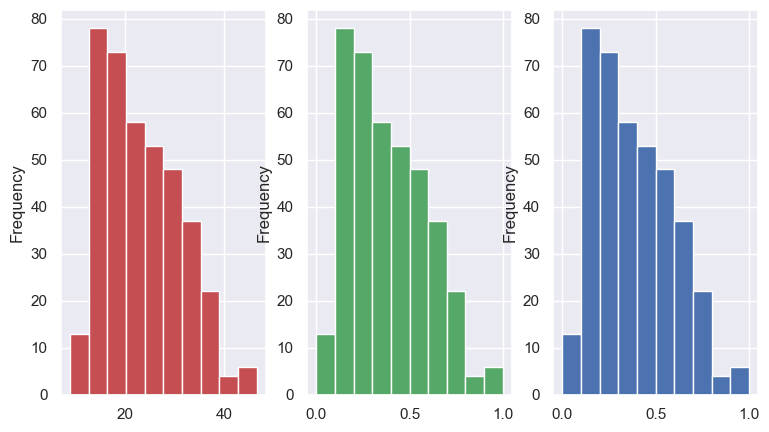

In [57]:
fig1, ax1 = plt.subplots(1,3, figsize=(9,5))

data['mpg'].plot(kind='hist', ax=ax1[0], color='r')

data['mpg_mxm'].plot(kind='hist', ax=ax1[1], color='g')

data['mpg_mxm_ft'].plot(kind='hist', ax=ax1[2], color='b')

In [58]:
print(data['mpg_mxm_ft'].min())
print(data['mpg_mxm_ft'].max())

0.0
1.0000000000000002


### Standard Scaling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

* **Standardization** does not change the shape of the distribution, and it does not transform non-normally distributed data into normally distributed data, [4].

* **Standardization** maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to *min-max scaling*, which scales the data to a limited range of values, [4].

* The `StandardScaler` class is fit only **once**, on the training data; those parameters are then used to transform the test dataset or any new data point, [4].

$$z = \frac{x - \mu}{s}$$

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[['FEA']])
df['FEA'] = scaler.transform(df[['FEA']])

# view the parameters of the scaler:
scaler.mean_
scaler.scale_
scaler.var_
```

The `.fit_transofrm` method combines both `.fit` and `.transform`:

```python
sk_standard_scaler = StandardScaler()
sk_standard_scaled_x_train = sk_standard_scaler.fit_transform(_Xtrain)
sk_standard_scaled_x_test = sk_standard_scaler.transform(X_test)
```

In [59]:
sc = '_std'
nums_std = []
for s in nums:
    s = s + sc
    nums_std.append(s)
print(nums_std)

['mpg_std', 'displacement_std', 'horsepower_std', 'weight_std', 'acceleration_std']


In [60]:
std_Scaler = preprocessing.StandardScaler()

std_Scaler.fit(data[nums])

data[nums_std] = std_Scaler.transform(data[nums])
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,...,displacement_mxm,horsepower_mxm,weight_mxm,acceleration_mxm,mpg_mxm_ft,mpg_std,displacement_std,horsepower_std,weight_std,acceleration_std
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,...,0.617571,0.456522,0.536150,0.238095,0.239362,-0.698638,1.077290,0.664133,0.620540,-1.285258
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,...,0.728682,0.646739,0.589736,0.208333,0.159574,-1.083498,1.488732,1.574594,0.843334,-1.466724
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,...,0.645995,0.565217,0.516870,0.178571,0.239362,-0.698638,1.182542,1.184397,0.540382,-1.648189
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,...,0.609819,0.565217,0.516019,0.238095,0.186170,-0.955212,1.048584,1.184397,0.536845,-1.285258
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,...,0.604651,0.510870,0.520556,0.148810,0.212766,-0.826925,1.029447,0.924265,0.555706,-1.829655


In [61]:
data['weight_std_ft'] = std_Scaler.fit_transform(data[['weight']])
data.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration,origin_ohe_1,...,horsepower_mxm,weight_mxm,acceleration_mxm,mpg_mxm_ft,mpg_std,displacement_std,horsepower_std,weight_std,acceleration_std,weight_std_ft
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0,0.0,...,0.456522,0.536150,0.238095,0.239362,-0.698638,1.077290,0.664133,0.620540,-1.285258,0.620540
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5,0.0,...,0.646739,0.589736,0.208333,0.159574,-1.083498,1.488732,1.574594,0.843334,-1.466724,0.843334
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0,0.0,...,0.565217,0.516870,0.178571,0.239362,-0.698638,1.182542,1.184397,0.540382,-1.648189,0.540382
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0,0.0,...,0.565217,0.516019,0.238095,0.186170,-0.955212,1.048584,1.184397,0.536845,-1.285258,0.536845
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5,0.0,...,0.510870,0.520556,0.148810,0.212766,-0.826925,1.029447,0.924265,0.555706,-1.829655,0.555706


In [62]:
data.weight_std_ft.describe()

count    3.920000e+02
mean    -1.812609e-17
std      1.001278e+00
min     -1.608575e+00
25%     -8.868535e-01
50%     -2.052109e-01
75%      7.510927e-01
max      2.549061e+00
Name: weight_std_ft, dtype: float64

<Axes: ylabel='Frequency'>

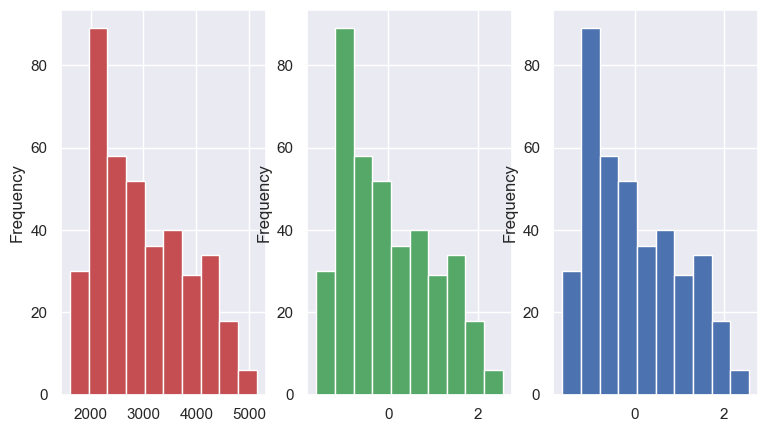

In [63]:
fig2, ax2 = plt.subplots(1,3, figsize=(9,5))

data['weight'].plot(kind='hist', ax=ax2[0], color='r')

data['weight_std'].plot(kind='hist', ax=ax2[1], color='g')

data['weight_std_ft'].plot(kind='hist', ax=ax2[2], color='b')

In [64]:
print(std_Scaler.mean_)
print(std_Scaler.scale_)
print(std_Scaler.var_)

[2977.58418367]
[848.31844657]
[719644.18679066]


## Randomly Divide the Dataframe [3, 4]

```python
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,
                                                    random_state=0,
                                                   stratify=y)
```
`stratify=y` ensures that both training and test datasets have the same class proportions as the original dataset, [4].

## Scale the Independent Features [3]

```python
from sklearn.preprocessing import StandardScaler
sk_standard_scaler = StandardScaler()
sk_standard_scaled_x_train = sk_standard_scaler.fit_transform(x_train)
sk_standard_scaled_x_test = sk_standard_scaler.transform(x_test)
```

## Things to Consider when Preparing Data [4]

### Dealing with Missing Data

* Delete
* Replace with the summary
* Random replace
* Use a predictive model

### Removing Duplicate Rows

### Handling Categorical Data

* Create a dummy variable
* Convert to number

### Normalizing Data

### Feature Construction or Generation